# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [2]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sympy import Symbol, lambdify, sin

# Pomocnicze funkcje

In [3]:
def plot_fn(fn, min_x, max_x, *, label='', title='Plot', color='b', step=.1, ax=plt):
    xs = np.arange(min_x, max_x, step)
    ax.plot(xs, [fn(x) for x in xs], color, label=label)
    if label: ax.legend(loc='best')
    
    if ax is plt:
        ax.title(title)
        ax.xlabel('x')
        ax.ylabel('y')
    else:
        ax.title.set_text(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    ax.grid()
    
    sns.despine()
    
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

## Wyznaczanie węzłów zgodnie z zerami wielomianu Czebyszewa

In [4]:
def chebyshev_nodes(a, b, n):
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

# Interpolacja Hermite'a

In [5]:
def memoized(fn):
    cache = {}

    def inner(arg):
        if arg not in cache:
            cache[arg] = fn(arg)
        return cache[arg]
        
    return inner

@memoized
def factorial(n):
    if n in {0, 1}: return 1
    return n * factorial(n - 1)

def hermite(xs: list[int], ys: list[list[int]]):
    ms = [len(y_list) for y_list in ys]
    n = sum(ms)
    
    xs_ = []
    for i in range(len(xs)):
        xs_.extend([xs[i]] * ms[i])
    
    # Create a matrix of coefficients
    bs = [[None] * n for _ in range(n)]
    
    # Fill a matrix with known values
    i = 0
    for y_list in ys:
        for j in range(len(y_list)):
            for k in range(j + 1):
                bs[i][k] = y_list[k] / factorial(k)
            i += 1
            
    # Fill the remaining triangular part of a matrix
    for j in range(1, n):
        for i in range(j, n):
            if bs[i][j] is not None: 
                continue
            bs[i][j] = (bs[i][j - 1] - bs[i - 1][j - 1]) / (xs_[i] - xs_[i - j])
            
    # Rewrite coefficients to the linear array
    bs_ = [bs[i][i] for i in range(n)]
    
    # Create and return interpolating function
    def f(x):
        x_diffs = [1] + [x - xs_[i] for i in range(n - 1)]
        
        y = 0
        x_coeff = 1
        for bi, x_diff in zip(bs_, x_diffs):
            x_coeff *= x_diff
            y += bi * x_coeff
            
        return y
            
    return f

In [6]:
hermite([1, 2], [[1, 4], [3, 1, 1]])

<function __main__.hermite.<locals>.f(x)>

# Zadania

## Interpolowana funkcja

### Wzór funkcji

$\Large{f(x)=e^{-k\cdot{sin(mx)}}+k\cdot{sin(mx)}-1}$

gdzie $k=2$, $m=2$, $x\in[-\pi,2\pi]$

In [7]:
f = lambda x, k, m: math.e ** (-k * math.sin(m * x)) + k * math.sin(m * x) - 1

In [8]:
k = 2
m = 2
a = -math.pi
b = 2 * math.pi
x = [a, b]

g = lambda x: f(x, k, m)

### Wykres funkcji

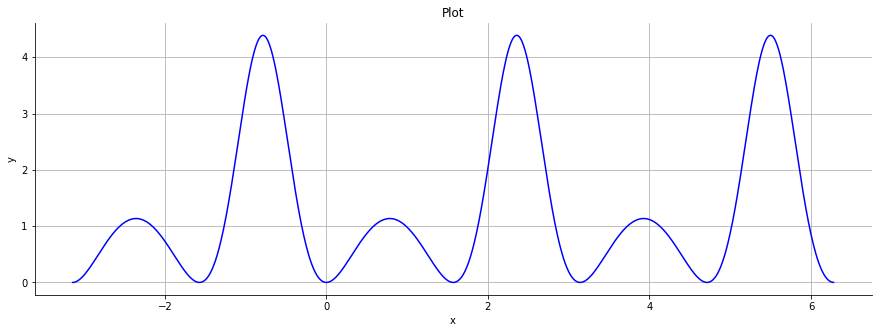

In [9]:
plt.figure(figsize=(15, 5))
plot_fn(g, a, b, step=.01)
plt.show()

## Dokładność przybliżenia funkcji interpolowanej przez wielomian interpolujący 

Przyjmijmy następujące oznaczenia:

$f(x)$ - interpolowana funkcja (funkcja wzorcowa)

$W(x)$ - wielomian interpolujący (przybliżający funkcję wzorcową)

### Norma z różnicy

$||f(x)-W(x)||$

In [10]:
def abs_diff(f, W, xs):
    return [abs(f(x) - W(x)) for x in xs]

### Największa różnica

$max_k\{||f(x_k)-W(x_k)||\}$

In [11]:
def max_diff(f, W, xs):
    return max(abs_diff(f, W, xs))

### Suma kwadratów różnic

$\sum\limits_{i = 1}^{N} (f(x_i) - W(x_i))^2$

In [12]:
def sum_sq_diff(f, W, xs):
    return sum(d ** 2 for d in abs_diff(f, W, xs))

## Interpolacja

### Pomocnicze funkcje

###### Wykresy

In [13]:
def plot_interpolation(f, xs, ys, N=1000):
    W = hermite(xs, ys)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    
    # Compare interpolation polynomial to the original function
    plot_fn(f, a, b, step=.01, color='#777', label='f', ax=ax[0])
    plot_fn(W, a, b, step=.01, label='Hermite\'s', title='Interpolation plot', ax=ax[0])
    
    # Create errors plot
    xs_ = np.linspace(a, b, N)
    diffs = abs_diff(f, W, xs_)
    ax[1].scatter(xs_, diffs)
    
    ax[0].scatter(xs, [y_list[0] for y_list in ys])
    plt.show()

###### Wyznaczanie funkcji pochodnych

In [14]:
from math import e
x = Symbol('x')
g0_ = e**(-2*sin(2*x))+2*sin(2*x)-1
g1_ = g0_.diff(x)
g2_ = g1_.diff(x 
g3_ = g2_.diff(x)

# Create callable functions from g1, g2, g3 objects
g1 = lambdify(x, g1_)
g2 = lambdify(x, g2_)
g3 = lambdify(x, g3_)
gs = [g, g1, g2, g3]

###### Funkcja g (zerowa pochodna)

In [15]:
g0_

2*sin(2*x) - 1 + 2.71828182845905**(-2*sin(2*x))

###### Funkcja g1 (pierwsza pochodna)

In [16]:
g1_

4*cos(2*x) - 4.0*cos(2*x)/2.71828182845905**(2*sin(2*x))

###### Funkcja g2 (druga pochodna)

In [17]:
g2_

-8*sin(2*x) + 8.0*sin(2*x)/2.71828182845905**(2*sin(2*x)) + 16.0*cos(2*x)**2/2.71828182845905**(2*sin(2*x))

###### Funkcja g3 (trzecia pochodna)

In [18]:
g3_

-16*cos(2*x) - 96.0*sin(2*x)*cos(2*x)/2.71828182845905**(2*sin(2*x)) - 64.0*cos(2*x)**3/2.71828182845905**(2*sin(2*x)) + 16.0*cos(2*x)/2.71828182845905**(2*sin(2*x))

###### Pozostałe

In [19]:
def derivatives(x, n):
    return list(map(lambda g: g(x), gs[:n+1]))

### Przykłady

[0.9557061369255526, -2.7828834014142494, -3.101277512602074, 4.439516976538828, 5.309385865134698, 2.185886516664242, 3.3741495164479356, 6.242870166191867, -1.2979243229490351]


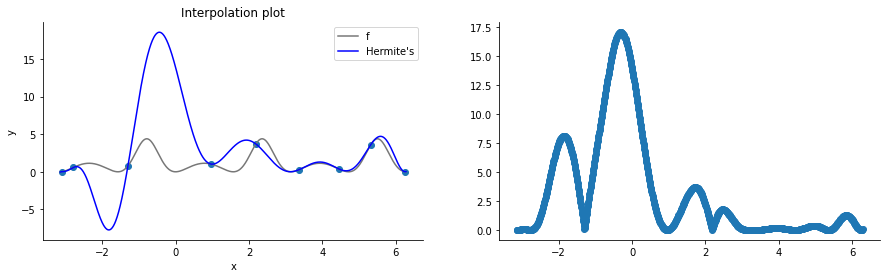

In [24]:
from random import randint, sample, seed

n = 12
xs = chebyshev_nodes(a, b, n)
xs_ = sample(xs, int(n * .75))
print(xs_)
ds = [randint(0, 1) for _ in range(len(xs_))] # Derivatives order

ys = [derivatives(x, d) for x, d in zip(xs_, ds)]

plot_interpolation(g, xs_, ys)